In [1]:
import pandas as pd

blood_ptau = pd.read_csv('/Users/larsheijnen/Thesis/data/blood/BLOOD_DATE_FORMATTED_CSF_FILTERED_PTAU.csv')

In [2]:
# Find PATNOs with exactly 5 occurrences
patnos_with_5_visits = blood_ptau['PATNO'].value_counts()
patnos_with_5_visits = patnos_with_5_visits[patnos_with_5_visits == 5].index.tolist()

print("PATNOs with 5 visits:", patnos_with_5_visits)

PATNOs with 5 visits: [3528, 3771, 41568, 92490, 3775, 41288, 3527, 51689, 16580, 3116, 51782, 14281, 3530, 3009, 60003, 41523, 3854, 51392, 51440, 41522, 40338, 60074, 3130, 3305, 41526, 51540, 41529, 3127, 51551, 41562, 52678, 4135, 51867, 52275, 3100, 3088, 60057, 3028, 4058, 4109, 3515, 41578, 52523, 50044, 60065, 3325, 52400, 3027, 42171, 50225, 52524, 52530, 3106, 52062, 3831, 60035, 3358, 3908, 3360, 3112, 3522, 3793, 4123, 4100, 51330, 41519, 41486, 4071, 40725, 3564, 50319, 50509, 41382, 4072, 40704, 3226, 3615, 50455, 3171, 50379, 40713, 3607, 3224, 3212, 3223, 40754, 3175, 3593, 3592, 3591, 40776, 3572, 3029, 3584, 40882, 40893, 3900, 54144, 50860, 3960, 3478, 40587, 3480, 3274, 51186, 41412, 3414, 41410, 3665, 3664, 40602, 40603, 3417, 3967, 3260, 60100, 3190, 3430, 3634, 3476, 53988, 3635, 3653, 3054]


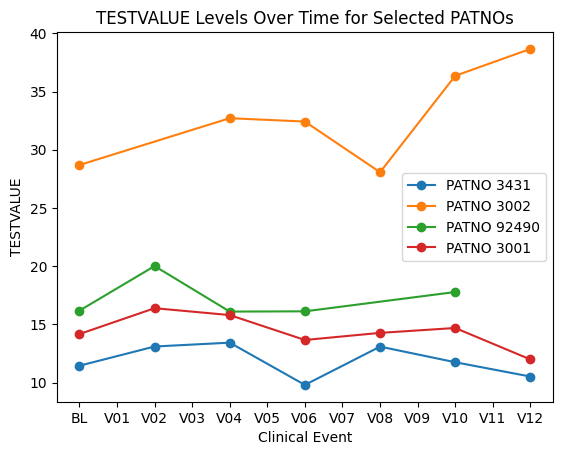

In [4]:
import matplotlib.pyplot as plt

# Define the function to plot the data
def plot_patnos(df, patnos):
    # Define the event order and mapping
    event_order = ['BL'] + [f'V{i:02d}' for i in range(1, 13)]  # Adjust range as needed
    event_map = {event: idx for idx, event in enumerate(event_order)}

    # Filter the data for the specified PATNOs
    filtered_data = df[df['PATNO'].isin(patnos)]

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the temporal change for each PATNO
    for patno in patnos:
        patient_data = filtered_data[filtered_data['PATNO'] == patno].copy()
        patient_data['TESTVALUE'] = pd.to_numeric(patient_data['TESTVALUE'], errors='coerce')
        patient_data['order'] = patient_data['CLINICAL_EVENT'].astype(str).map(event_map)
        patient_data = patient_data.dropna(subset=['order']).sort_values(by='order')
        ax.plot(patient_data['order'], patient_data['TESTVALUE'], marker='o', label=f"PATNO {patno}")

    # Set axis labels and ticks
    ax.set_xticks(list(event_map.values()))
    ax.set_xticklabels(list(event_map.keys()))
    ax.set_xlabel("Clinical Event")
    ax.set_ylabel("TESTVALUE")
    ax.set_title("TESTVALUE Levels Over Time for Selected PATNOs")
    ax.legend()

    plt.show()

# Example usage
selected_patnos = [3431, 3002, 92490, 3001]  # Replace with your desired PATNOs
plot_patnos(blood_ptau, selected_patnos)

Pearson correlation: 0.0117
P-value: 0.4560


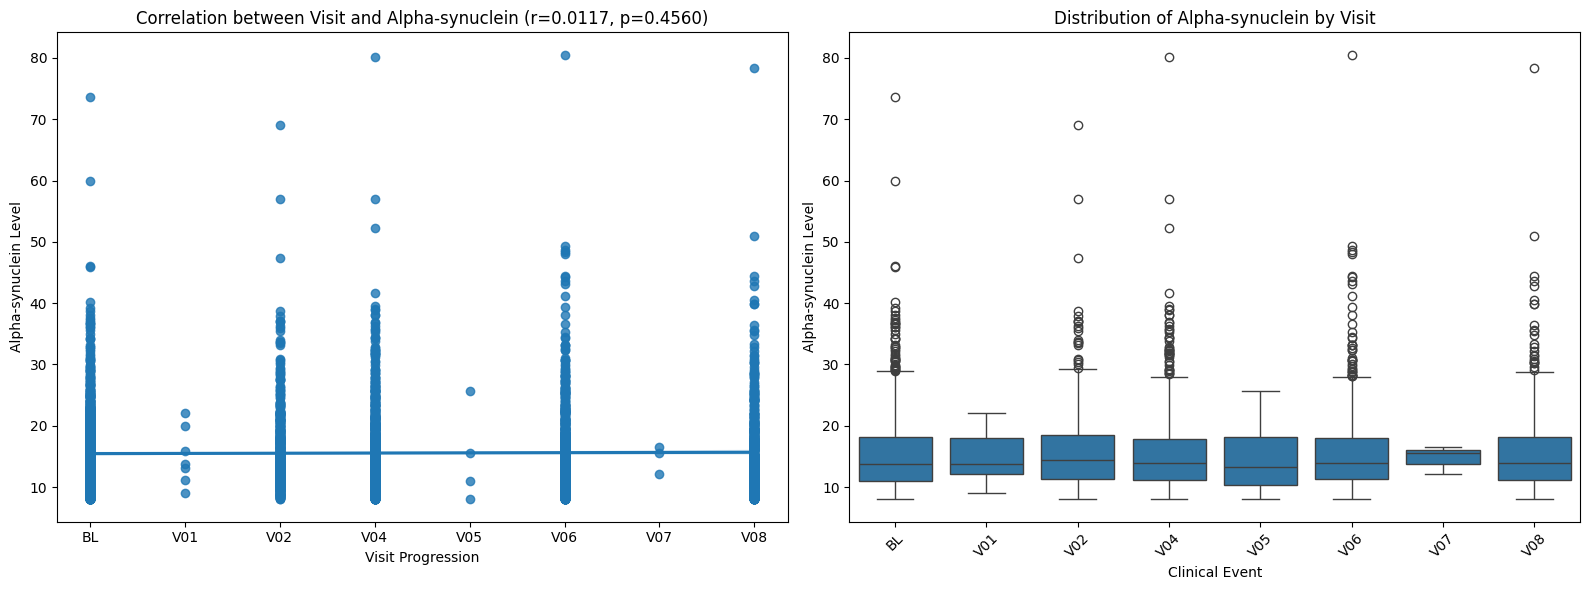


ANOVA results:
F-statistic: 0.6171
P-value: 0.7423
No significant differences between visits


In [5]:
# Convert CLINICAL_EVENT to numeric values for correlation analysis
import numpy as np
import scipy.stats as stats
import seaborn as sns

# Define the visit order
event_order = ['BL', 'V01', 'V02', 'V04', 'V05', 'V06', 'V07', 'V08']
event_map = {event: idx for idx, event in enumerate(event_order)}

# Create a copy to avoid modifying the original dataframe
alpha_syn_analysis = blood_ptau.copy()

# Convert CLINICAL_EVENT to numeric and TESTVALUE to numeric
alpha_syn_analysis['visit_numeric'] = alpha_syn_analysis['CLINICAL_EVENT'].map(event_map)
alpha_syn_analysis['TESTVALUE'] = pd.to_numeric(alpha_syn_analysis['TESTVALUE'], errors='coerce')

# Drop rows with missing values for analysis
clean_data = alpha_syn_analysis.dropna(subset=['visit_numeric', 'TESTVALUE'])

# Calculate correlation
correlation, p_value = stats.pearsonr(clean_data['visit_numeric'], clean_data['TESTVALUE'])
print(f"Pearson correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Scatter plot with regression line
sns.regplot(x='visit_numeric', y='TESTVALUE', data=clean_data, ax=ax1)
ax1.set_xlabel('Visit Progression')
ax1.set_ylabel('Alpha-synuclein Level')
ax1.set_title(f'Correlation between Visit and Alpha-synuclein (r={correlation:.4f}, p={p_value:.4f})')
ax1.set_xticks(range(len(event_order)))
ax1.set_xticklabels(event_order)

# 2. Box plot to show distribution by visit
sns.boxplot(x='CLINICAL_EVENT', y='TESTVALUE', data=clean_data, order=event_order, ax=ax2)
ax2.set_xlabel('Clinical Event')
ax2.set_ylabel('Alpha-synuclein Level')
ax2.set_title('Distribution of Alpha-synuclein by Visit')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Check if there are significant differences between visits using ANOVA
groups = [clean_data[clean_data['CLINICAL_EVENT'] == event]['TESTVALUE'].values for event in event_order if event in clean_data['CLINICAL_EVENT'].values]
groups = [group for group in groups if len(group) > 0]  # Remove empty groups

if len(groups) > 1:  # Need at least 2 groups for ANOVA
    f_stat, anova_p = stats.f_oneway(*groups)
    print(f"\nANOVA results:")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {anova_p:.4f}")
    print(f"{'There are significant differences between visits' if anova_p < 0.05 else 'No significant differences between visits'}")